## Mask Adaptivity Detection Using YOLO
![cover](https://i.ibb.co/RBG6m20/cover.png)

In [0]:
import warnings
import numpy as np
import argparse
import time
import cv2
import os
warnings.filterwarnings("ignore")

### Prepare DarkNet Environment

In [2]:
# Create DarkNet Environment
def prepare_environment():
    os.environ['PATH'] += ':/usr/local/cuda/bin'
    !rm -fr darknet
    !git clone https://github.com/AlexeyAB/darknet/
    !apt install gcc-5 g++-5 -y
    !ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc 
    !ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++
    %cd darknet
    !sed -i 's/GPU=0/GPU=1/g' Makefile
    !sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
    !make
    # get yolov3 weights
    #!wget https://pjreddie.com/media/files/darknet53.conv.74.weights
    !chmod a+x ./darknet
    !apt install ffmpeg libopencv-dev libgtk-3-dev python-numpy python3-numpy libdc1394-22 libdc1394-22-dev libjpeg-dev libtiff5-dev libavcodec-dev libavformat-dev libswscale-dev libxine2-dev libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev libv4l-dev libtbb-dev qtbase5-dev libfaac-dev libmp3lame-dev libopencore-amrnb-dev libopencore-amrwb-dev libtheora-dev libvorbis-dev libxvidcore-dev x264 v4l-utils unzip
    status='Completed'
    return status
prepare_environment()    

Cloning into 'darknet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 13567 (delta 1), reused 1 (delta 0), pack-reused 13559
Receiving objects: 100% (13567/13567), 12.20 MiB | 1.60 MiB/s, done.
Resolving deltas: 100% (9256/9256), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-5 gcc-5-base libasan2 libgcc-5-dev libisl15 libmpx0 libstdc++-5-dev
Suggested packages:
  gcc-5-locales g++-5-multilib gcc-5-doc libstdc++6-5-dbg gcc-5-multilib
  libgcc1-dbg libgomp1-dbg libitm1-dbg libatomic1-dbg libasan2-dbg
  liblsan0-dbg libtsan0-dbg libubsan0-dbg libcilkrts5-dbg libmpx0-dbg
  libquadmath0-dbg libstdc++-5-doc
The following NEW packages will be installed:
  cpp-5 g++-5 gcc-5 gcc-5-base libasan2 libgcc-5-dev libisl15 libmpx0
  libstdc++-5-dev
0 upgraded, 9 newly installed, 0 to remove 

'Completed'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [32]:
os.listdir('/content/drive/My Drive/darknet/TwoClass/YOLO_Custom')

['obj.names',
 'obj.data',
 'train.txt',
 'test.txt',
 'yolov3-tiny_obj_test.cfg',
 'yolov3-tiny_obj_train.cfg',
 'images',
 'yolov3-tiny_obj_train_tiny8.weights',
 'yolov3_train.cfg',
 'yolov3_test.cfg']

### Get Tiny YOLO Weight (Skip if Resuming Training)

In [33]:
!wget --header="Host: pjreddie.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://github.com/AlexeyAB/darknet" --header="Cookie: __utma=134107727.1364647705.1589636782.1589689587.1589901067.3; __utmz=134107727.1589901067.3.3.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided)" --header="Connection: keep-alive" "https://pjreddie.com/media/files/yolov3-tiny.weights" -c -O 'yolov3-tiny.weights'

--2020-05-28 10:45:03--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  64.2KB/s    in 12m 13s 

2020-05-28 10:57:18 (47.2 KB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



In [34]:
!./darknet partial cfg/yolov3-tiny.cfg yolov3-tiny.weights yolov3-tiny.conv.15 15

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
 GPU isn't used 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
   9 max                2x 2/ 2     26 x  26 x 

### Copy Required Files from Drive

In [0]:
# Copy fils from Google Drive to the VM local filesystem
!cp -r "/content/drive/My Drive/darknet/TwoClass/YOLO_Custom" /content/darknet/YOLO_Custom


### Train

Use the below command to train yolo:  
               
!./darknet detector train data_file_path config_file_path training_weights_path log_path

To train yolov3 instead of tiny yolo, replace the following files:

use ***yolov3_train_cfg*** instead of ***yolov3-tiny_obj_train.cfg***
use ***yolov3_test_cfg*** instead of ***yolov3-tiny_obj_test.cfg*** for testing purpose.
Replace the yolov3 weight link with the tiny yolo weight link

In [36]:
!./darknet detector train "/content/darknet/YOLO_Custom/obj.data" "/content/darknet/YOLO_Custom/yolov3-tiny_obj_train.cfg" "/content/darknet/yolov3-tiny.conv.15" "train.log" -dont_show 

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV version: 3.2.0
yolov3-tiny_obj_train
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 

### Utility Functions

In [0]:
# Define threshold for confidence score and Non max supression here
confthres=0.2
nmsthres=0.1
path="./"
def get_labels(label_dir):
    return open(label_dir).read().split('\n')
      
def get_colors(LABELS):
    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")
    return COLORS

def get_weights(weights_path):
    # derive the paths to the YOLO weights and model configuration
    weightsPath = os.path.sep.join([yolo_path, weights_path])
    return weightsPath

def get_config(config_path):
    configPath = os.path.sep.join([yolo_path, config_path])
    return configPath

def load_model(configpath,weightspath):
    # load our YOLO object detector trained on COCO dataset (80 classes)
    print("[INFO] loading YOLO from disk...")
    net = cv2.dnn.readNetFromDarknet(configpath, weightspath)
    return net

In [0]:
#https://medium.com/analytics-vidhya/object-detection-using-yolo-v3-and-deploying-it-on-docker-and-minikube-c1192e81ae7a
def get_predection(image,net,LABELS,COLORS):
    (H, W) = image.shape[:2]

    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    #print(layerOutputs[0])
    end = time.time()

    # show timing information on YOLO
    #print("[INFO] YOLO took {:.6f} seconds".format(end - start))

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []
    num_class_0 = 0
    num_class_1 = 0

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            #print(detection)
            classID = np.argmax(scores)
            # print(classID)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > confthres:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                if(classID==0):
                  num_class_0 +=1
                elif(classID==1):
                  num_class_1 +=1  

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confthres,
                            nmsthres)
    if(num_class_0>0 or num_class_1>0):
        index= num_class_0/(num_class_0+num_class_1)
    else:
      index=-1  
    #print(index,)    
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}".format(LABELS[classIDs[i]])
            #print(boxes)
            #print(classIDs)      
            #cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color=(69, 60, 90), thickness=2)
            cv2.rectangle(image, (x, y-5), (x+62, y-15), color, cv2.FILLED)
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,0), 1)
            if(index!=-1 and index<.50):
                cv2.rectangle(image, (40, 46), (220, 16), (0,0,255), cv2.FILLED)
                cv2.putText(image,'Mask Adaptivity: POOR',(40,40),cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,255,255), 1)
            elif(index>=.50 and index<.70):
                cv2.rectangle(image, (40, 46), (255, 16), (0, 165, 255), cv2.FILLED)
                cv2.putText(image,'Mask Adaptivity: MODERATE',(40,40),cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,0), 1)  
            elif(index>=0.70):
                cv2.rectangle(image, (40, 46), (220, 16), (42,236,42), cv2.FILLED)
                cv2.putText(image,'Mask Adaptivity: HIGH',(40,40),cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,0), 1)      
    return image

In [0]:
def predict_image(img_path):
    image = cv2.imread(img_path)
    nets=load_model(CFG,Weights)
    #Colors=get_colors(Lables)
    Colors=[(42,236,42),(0,0,255)]
    res=get_predection(image,nets,Lables,Colors)
    # image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # show the output image
    cv2_imshow(res)
    cv2.waitKey()

In [0]:
def predict_video(input_path,output_path):
    vid = cv2.VideoCapture(input_path)
    op=output_path
    height, width = None, None
    writer = None
    print('[Info] processing Video (It may take several minutes to Run)..')
    while True:
        grabbed, frame = vid.read()
		    # Checking if the complete video is read
        if not grabbed:
		        break
        if width is None or height is None:
		        height, width = frame.shape[:2]
        frame=get_predection(frame,nets,Lables,Colors)
        if writer is None:
          fourcc = cv2.VideoWriter_fourcc(*"mp4v")
          writer = cv2.VideoWriter(op, fourcc, 27,(frame.shape[1], frame.shape[0]), True)
        writer.write(frame)
    print ("[INFO] Cleaning up...")
    writer.release()
    vid.release()
    print ("[INFO] Prediction Completed.")


In [0]:
# This will not work  in colab, as colab can't access local hardware
import time
def predict_web_cam():
    #stream = cv2.VideoCapture(0)
    sess = K.get_session()
    while True:
        # Capture frame-by-frame
        grabbed, frame = stream.read()
        if not grabbed:
            break
        # Run detection
        start = time.time()
        image = Image.fromarray(frame)
        output_image =  get_predection(image,nets,Lables,Colors)
        end = time.time()
        print("Inference time: {:.2f}s".format(end - start))
        # Display the resulting frame
        cv2.imshow('Web Cam',np.asarray(output_image))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    stream.release()    
    cv2.destroyAllWindows() 

### Set the Variables (Must before Prediction)

In [0]:
# Set the pah for test config file, label directory and weights
CFG='/content/darknet/YOLO_Custom/yolov3-tiny_obj_test.cfg'   
label_dir='/content/darknet/YOLO_Custom/obj.names'
cfgpath=test_config_path
Weights='/content/darknet/YOLO_Custom/yolov3-tiny_obj_train_tiny8.weights'
Lables=get_labels(label_dir)


### Predict Image

[INFO] loading YOLO from disk...


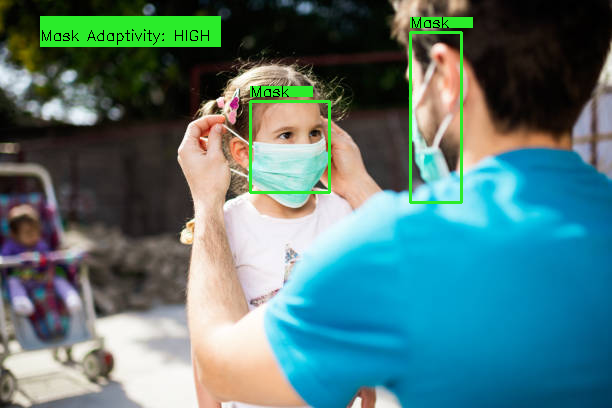

In [30]:
    from google.colab.patches import cv2_imshow
    img_path='/content/darknet/YOLO_Custom/images/image_502.jpg' 
    predict_image(img_path) 

### Predict Video

In [0]:
input_path='/content/in.mp4'
output_path='/content/out.mp4'
predict_video(input_path,output_path)

processing..
[INFO] Cleaning up...
